# Base Hopping using Brian Evaluation

In [90]:
import numpy as np
from brian2 import *
from brian2tools import *
from sympy import *
from brian2.units.fundamentalunits import DIMENSIONLESS
from scipy.optimize import basinhopping, minimize
from tqdm import tqdm

## Senstivity to Create The new system of Equations

In [2]:
def get_sensitivity_equations(group, parameters):
    eqs = group.equations
    diff_eqs = eqs.get_substituted_expressions(group.variables)
    diff_eq_names = [name for name, _ in diff_eqs]

    system = Matrix([diff_eq[1] for diff_eq in diff_eqs])
    J = system.jacobian(diff_eq_names)

    sensitivity = []
    sensitivity_names = []
    for parameter in parameters:
        F = system.jacobian([parameter])
        names = ['S_{}_{}'.format(diff_eq_name, parameter)
                 for diff_eq_name in diff_eq_names]
        sensitivity.append(J * Matrix(names) + F)
        sensitivity_names.append(names)

    new_eqs = []
    for names, sensitivity_eqs, param in zip(sensitivity_names, sensitivity, parameters):
        for name, eq, orig_var in zip(names, sensitivity_eqs, diff_eq_names):
            unit = eqs[orig_var].dim / group.namespace[parameter].dim
            new_eqs.append('d{lhs}/dt = {rhs} : {unit}'.format(lhs=name,
                                                           rhs=eq,
                                                           unit=repr(unit) if unit is not DIMENSIONLESS else '1'))
    new_eqs = Equations('\n'.join(new_eqs))
    return new_eqs

## Neuron Example with HH

In [3]:
dt = 0.1 * ms
defaultclock.dt = dt

In [4]:
duration = 2*second

# Parameters
area = 20000*umetre**2
# gl = 5e-5*siemens*cm**-2 * area
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV

In [5]:
# The model
eqs = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I) / Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I: amp 
'''
)

In [6]:
start_scope()

In [7]:
group = NeuronGroup(1, eqs,
                    method='exponential_euler',
                    namespace={'gl': 5e-5*siemens*cm**-2 * area,})
group.I = '1*nA'
group.v = El
mon = StateMonitor(group, ['v', 'I'], record=True)

In [8]:
run(20*ms)

In [9]:
output = mon.v_[0]
# output

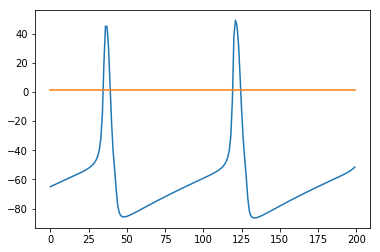

In [10]:
plt.plot(mon.v[0]/mV);
plt.plot(mon.I[0]/nA);

In [11]:
new_eqs = get_sensitivity_equations(group, ['gl'])
new_eqs

dS_v_gl/dt = -S_h_gl*g_na*m**3.0*(-ENa + v)/Cm - 3.0*S_m_gl*g_na*h*m**2.0*(-ENa + v)/Cm - 4.0*S_n_gl*g_kd*n**3.0*(-EK + v)/Cm + S_v_gl*(-g_kd*n**4.0 - g_na*h*m**3.0 - gl)/Cm + (El - v)/Cm : metre ** 4 * kilogram ** 2 * second ** -6 * amp ** -3
dS_m_gl/dt = S_m_gl*(-0.32*mV**(-1.0)*(VT + 13.0*mV - v)/(ms*(exp((0.25*VT + 3.25*mV - 0.25*v)/mV) - 1.0)) - 0.28*mV**(-1.0)*(-VT - 40.0*mV + v)/(ms*(exp((-0.2*VT - 8.0*mV + 0.2*v)/mV) - 1.0))) + S_v_gl*(0.056*m*mV**(-2.0)*(exp((-0.2*VT - 8.0*mV + 0.2*v)/mV) - 1.0)**(-2.0)*(-VT - 40.0*mV + v)*exp((-0.2*VT - 8.0*mV + 0.2*v)/mV)/ms - 0.28*m*mV**(-1.0)/(ms*(exp((-0.2*VT - 8.0*mV + 0.2*v)/mV) - 1.0)) + 0.08*mV**(-2.0)*(1.0 - m)*(exp((0.25*VT + 3.25*mV - 0.25*v)/mV) - 1.0)**(-2.0)*(VT + 13.0*mV - v)*exp((0.25*VT + 3.25*mV - 0.25*v)/mV)/ms - 0.32*mV**(-1.0)*(1.0 - m)/(ms*(exp((0.25*VT + 3.25*mV - 0.25*v)/mV) - 1.0))) : ohm
dS_n_gl/dt = S_n_gl*(-0.032*mV**(-1.0)*(VT + 15.0*mV - v)/(ms*(exp((0.2*VT + 3.0*mV - 0.2*v)/mV) - 1.0)) - 0.5*exp((0.025*VT + 0.25

In [12]:
type(new_eqs)

brian2.equations.equations.Equations

### Create working model to plug into the function

In [13]:
# The model
eqs_fit = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I) / Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I: amp 
gl: siemens(constant)
'''
)

In [14]:
t_start=0*second
n_samples = 1

In [15]:
model = eqs_fit + new_eqs

In [16]:
Ntraces=1
Nsteps = output.shape
duration = Nsteps * dt
output_traces = TimedArray(output.transpose(), dt=dt)
output_var = 'v'

In [17]:
start_scope()

In [18]:
neurons = NeuronGroup(1, model,
                    method='exponential_euler',)


neurons.namespace['output_var'] = output_traces
neurons.namespace['Nsteps'] = Nsteps
neurons.namespace['Ntraces'] = Ntraces
neurons.namespace['t_start'] = t_start

In [19]:
d = 10 * nS
d

10. * nsiemens

In [20]:
d =  1.01 * 10*nS
d

10.1 * nsiemens

In [21]:
dp = d - 5e-5*siemens*cm**-2 * area
dp

100. * psiemens

In [22]:
state = {'gl': d}
neurons.set_states(state)

In [23]:
neurons.I = '1*nA'
neurons.v = El
mon = StateMonitor(neurons, ['v', 'I','S_v_gl', 'S_m_gl', 'S_n_gl', 'S_h_gl'], record=True)

In [24]:
run(20*ms)

In [25]:
trace = mon.v_[0]
E = np.sum(np.square(output - trace))
E

1.6481778295806795e-06

In [26]:
svgl = mon.S_v_gl_[0]
dEdp = np.sum(2 * svgl * output - 2 * svgl * trace)
dEdp

-34857.87041826462

## Same Evaluation but In a Function

In [79]:
def eval_neurons(d):
    start_scope()
    
    neurons = NeuronGroup(1, model, method='exponential_euler',)
    neurons.namespace['output_var'] = output_traces
    neurons.namespace['Nsteps'] = Nsteps
    neurons.namespace['Ntraces'] = Ntraces
    neurons.namespace['t_start'] = t_start
    neurons.I = '1*nA'
    neurons.v = El
    
    state = {'gl': d * nS}
    neurons.set_states(state)
    
    mon = StateMonitor(neurons, ['v', 'S_v_gl'], record=True)
    
    run(20*ms)

    trace = mon.v_[0]
    svgl = mon.S_v_gl_[0]
    E = np.sum(np.square(output - trace))
    dEdp = np.sum(2 * svgl * output - 2 * svgl * trace)
    
    return E, np.array([dEdp]), np.sum(svgl)/Nsteps

In [80]:
eval_neurons(10)

(3.240601321714113e-30, array([-1.18156009e-08]), array([87269.94511035]))

In [100]:
inp = np.arange(8,15,0.5)
sv, out, grad = [], [], []

for i in tqdm(inp):
    a, b, c = eval_neurons(i)
    out.append(a)
    grad.append(b[0])
    sv.append(c)

100%|██████████| 14/14 [00:37<00:00,  2.67s/it]


In [101]:
np.shape(out)

(14,)

## Viz The Evaluation

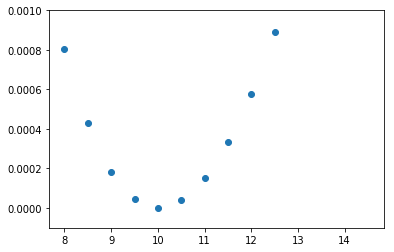

In [102]:
ylim(-0.0001, 0.001)
plt.scatter(inp, out);

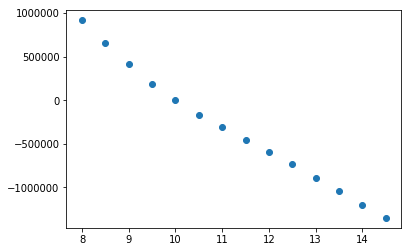

In [103]:
plt.scatter(inp, grad);

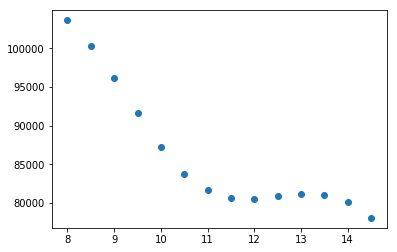

In [104]:
plt.scatter(inp, sv);

## Basinhoppin

In [29]:
x0 = [12]
minimizer_kwargs = {"method":"L-BFGS-B", "jac":True}
ret = basinhopping(eval_neurons, x0, minimizer_kwargs=minimizer_kwargs, niter=25)

In [30]:
print(ret.x[0], ret.fun)

10.93263400018564 0.0001338240107029903


In [31]:
x0 = [12]
minimizer_kwargs = {"method":"L-BFGS-B", "jac":True}
ret = basinhopping(eval_neurons, x0, minimizer_kwargs=minimizer_kwargs, niter=50)

In [32]:
print(ret.x[0], ret.fun)

10.408498004295556 2.676102874184157e-05


## Minimize

In [33]:
def eval_neur(d):
    start_scope()
    
    neurons = NeuronGroup(1, model, method='exponential_euler',)
    neurons.namespace['output_var'] = output_traces
    neurons.namespace['Nsteps'] = Nsteps
    neurons.namespace['Ntraces'] = Ntraces
    neurons.namespace['t_start'] = t_start
    neurons.I = '1*nA'
    neurons.v = El
    
    state = {'gl': d * nS}
    neurons.set_states(state)
    
    mon = StateMonitor(neurons, ['v', 'S_v_gl'], record=True)
    
    run(20*ms)

    trace = mon.v_[0]
    E = np.sum(np.square(output - trace))
    
    return E

In [34]:
def eval_neurons_grad(d):
    start_scope()
    
    neurons = NeuronGroup(1, model, method='exponential_euler',)
    neurons.namespace['output_var'] = output_traces
    neurons.namespace['Nsteps'] = Nsteps
    neurons.namespace['Ntraces'] = Ntraces
    neurons.namespace['t_start'] = t_start
    neurons.I = '1*nA'
    neurons.v = El
    
    state = {'gl': d * nS}
    neurons.set_states(state)
    
    mon = StateMonitor(neurons, ['v', 'S_v_gl'], record=True)
    
    run(20*ms)

    trace = mon.v_[0]
    svgl = mon.S_v_gl_[0]
    E = np.sum(np.square(output - trace))
    dEdp = np.sum(2 * svgl * output - 2 * svgl * trace)
    
    return dEdp

In [107]:
ret = minimize(eval_neur, [9], method='CG')

In [108]:
print(ret.x[0], ret.fun)

10.0020829946667 7.216198095617362e-10
